### Install liten
Must install latest liten before running the commands
Install from released package from pypi
```bash
$ pip install -i https://test.pypi.org/simple/ liten
```
Read local setup.py and install liten
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten
```
Install from local wheel file
```bash
pip install /mnt/c/Users/hkver/Documents/dbai/dbaistuff/py/liten/dist/liten-0.0.1-py3-none-any.whl
```

Import arrow and liten

In [1]:
import pyarrow as pa
from pyarrow import csv
import json
import pandas as pd

In [2]:
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten.lib' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


Name of the Tpch fact and dimension tables. Names must be unique. They are used in SQL queries.

In [3]:
fact_tables = ['lineitem']
dim_tables = ['customer','orders','supplier','nation','region','partsupp','part']
tpch_dir = '/mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/'

Create a Liten cache. Cache holds tabular data, tensor, and all other metadata. Print version information. Print worker nodes available on Liten cluster.

In [4]:
tc = ten.cache()

In [5]:
tc.version

'0.0.2'

In [6]:
pd.read_json(tc.compute_info())

,Compute
WorkerThreads,6


In [7]:
pa.show_versions()

pyarrow version info
--------------------
Package kind: not indicated
Arrow C++ library version: 4.0.1
Arrow C++ compiler: GNU 7.3.0
Arrow C++ compiler flags: -fvisibility-inlines-hidden -std=c++17 -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/hkverma/miniconda3/envs/liten/include -fdebug-prefix-map=/tmp/build/80754af9/arrow-cpp_1622562886179/work=/usr/local/src/conda/arrow-cpp-4.0.1 -fdebug-prefix-map=/home/hkverma/miniconda3/envs/liten=/usr/local/src/conda-prefix -fdiagnostics-color=always -O3 -DNDEBUG
Arrow C++ git revision: 
Arrow C++ git description: 


Utility functions used later 

In [8]:
def get_schemas():
    schemas = { }
    def add_schema(table_name):
        schema_name = table_name + "_schema"
        tschema = tc.get_schema(schema_name)
        schema_info = json.loads(tschema.get_info())
        schemas[schema_name] = schema_info
    for i in range(len(fact_tables)):
        add_schema(fact_tables[i])
    for i in range(len(dim_tables)):
        add_schema(dim_tables[i])
    return schemas

Read SF=1 Tpch Csv tables.  Schema is inferred from the csv files.

In [9]:
%%time
def read_tables(tables):
    arrow_tables = []
    for table_name in tables:
        tpch_table = tpch_dir+table_name+'.tbl'
        print('Reading ', tpch_table)
        pytable = pa.csv.read_csv(input_file=tpch_table, parse_options=csv_options)
        print(' Rows=', pytable.num_rows,' Cols=', pytable.num_columns)
        arrow_tables.append(pytable)
    return arrow_tables
csv_options = pa.csv.ParseOptions(delimiter='|')
pa_fact_tables = read_tables(fact_tables)
pa_dim_tables = read_tables(dim_tables)

Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/lineitem.tbl
 Rows= 6001215  Cols= 16
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/customer.tbl
 Rows= 150000  Cols= 8
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/orders.tbl
 Rows= 1500000  Cols= 9
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/supplier.tbl
 Rows= 10000  Cols= 7
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/nation.tbl
 Rows= 25  Cols= 4
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/region.tbl
 Rows= 5  Cols= 3
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/partsupp.tbl
 Rows= 800000  Cols= 5
Reading  /mnt/c/Users/hkver/Documents/dbai/tpch-kit/sf1g/part.tbl
 Rows= 200000  Cols= 9
CPU times: user 16.8 s, sys: 4.88 s, total: 21.7 s
Wall time: 4.18 s


Add fact and dimension tables to Liten Cache.

In [10]:
for i in range(len(fact_tables)):
    tc.add_table(fact_tables[i], pa_fact_tables[i], tc.FactTable)

In [11]:
for i in range(len(dim_tables)):
    tc.add_table(dim_tables[i], pa_dim_tables[i], tc.DimensionTable)

Print Liten cache information. The tables and schema should be visible now.

In [12]:
pd.read_json(tc.table_info())

,Table
customer,DimensionTable
lineitem,FactTable
nation,DimensionTable
orders,DimensionTable
part,DimensionTable
partsupp,DimensionTable
region,DimensionTable
supplier,DimensionTable


In [13]:
pd.read_json(tc.schema_info())

,Schema
customer_schema,DimensionTable
lineitem_schema,FactTable
nation_schema,DimensionTable
orders_schema,DimensionTable
part_schema,DimensionTable
partsupp_schema,DimensionTable
region_schema,DimensionTable
supplier_schema,DimensionTable


In [14]:
lineitem_schema = tc.get_schema('lineitem_schema')
lineitem_feature_fields = ['L_RECEIPTDATE','L_RETURNFLAG','L_SHIPDATE','L_SHIPINSTRUCT','L_SHIPMODE','L_COMMENT',
                          'L_COMMITDATE','L_LINENUMBER','L_LINESTATUS']
for feature_field in lineitem_feature_fields:                     
    lineitem_schema.set_field_type(feature_field, tc.FeatureField)

In [15]:
schemas = get_schemas()
pd.DataFrame(schemas['orders_schema']['schema']['fields'])

,O_CLERK,O_COMMENT,O_CUSTKEY,O_ORDERDATE,O_ORDERKEY,O_ORDERPRIORITY,O_ORDERSTATUS,O_SHIPPRIORITY,O_TOTALPRICE
datatype,string,string,int64,date32[day],int64,string,string,int64,double
type,FeatureField,FeatureField,FeatureField,FeatureField,FeatureField,FeatureField,FeatureField,FeatureField,FeatureField


In [16]:
pd.DataFrame(schemas['lineitem_schema']['schema']['fields'])

,L_COMMENT,L_COMMITDATE,L_DISCOUNT,L_EXTENDEDPRICE,L_LINENUMBER,L_LINESTATUS,L_ORDERKEY,L_PARTKEY,L_QUANTITY,L_RECEIPTDATE,L_RETURNFLAG,L_SHIPDATE,L_SHIPINSTRUCT,L_SHIPMODE,L_SUPPKEY,L_TAX
datatype,string,date32[day],double,double,int64,string,int64,int64,int64,date32[day],string,date32[day],string,string,int64,double
type,FeatureField,FeatureField,MetricField,MetricField,FeatureField,FeatureField,MetricField,MetricField,MetricField,FeatureField,FeatureField,FeatureField,FeatureField,FeatureField,MetricField,MetricField


Liten tensor is created by adding the relation ship between different tables

In [17]:
tc.join('lineitem_schema','L_ORDERKEY','orders_schema','O_ORDERKEY')
tc.join('orders_schema','O_CUSTKEY','customer_schema','C_CUSTKEY')
tc.join('customer_schema','C_NATIONKEY','nation_schema','N_NATIONKEY')
tc.join('nation_schema','N_REGIONKEY','region_schema','R_REGIONKEY')
tc.join('lineitem_schema','L_PARTKEY','partsupp_schema','PS_PARTKEY')
tc.join('partsupp_schema','PS_PARTKEY','part_schema','P_PARTKEY')
tc.join('partsupp_schema','PS_SUPPKEY','supplier_schema','S_SUPPKEY')

True

In [18]:
schemas = get_schemas()
pd.DataFrame(schemas['lineitem_schema']['schema'])

,fields,name,parent,type
L_COMMENT,"{'datatype': 'string', 'type': 'FeatureField'}",lineitem_schema,NaN,FactTable
L_COMMITDATE,"{'datatype': 'date32[day]', 'type': 'FeatureFi...",lineitem_schema,NaN,FactTable
L_DISCOUNT,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_EXTENDEDPRICE,"{'datatype': 'double', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_LINENUMBER,"{'datatype': 'int64', 'type': 'FeatureField'}",lineitem_schema,NaN,FactTable
L_LINESTATUS,"{'datatype': 'string', 'type': 'FeatureField'}",lineitem_schema,NaN,FactTable
L_ORDERKEY,"{'datatype': 'int64', 'type': 'DimensionField'}",lineitem_schema,"[orders_schema, O_ORDERKEY]",FactTable
L_PARTKEY,"{'datatype': 'int64', 'type': 'DimensionField'}",lineitem_schema,"[partsupp_schema, PS_PARTKEY]",FactTable
L_QUANTITY,"{'datatype': 'int64', 'type': 'MetricField'}",lineitem_schema,NaN,FactTable
L_RECEIPTDATE,"{'datatype': 'date32[day]', 'type': 'FeatureFi...",lineitem_schema,NaN,FactTable


In [19]:
pd.DataFrame(schemas['orders_schema']['schema'])

,child,fields,name,parent,type
O_ORDERKEY,"[lineitem_schema, L_ORDERKEY]","{'datatype': 'int64', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_CLERK,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_COMMENT,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_CUSTKEY,NaN,"{'datatype': 'int64', 'type': 'DimensionField'}",orders_schema,"[customer_schema, C_CUSTKEY]",DimensionTable
O_ORDERDATE,NaN,"{'datatype': 'date32[day]', 'type': 'FeatureFi...",orders_schema,NaN,DimensionTable
O_ORDERPRIORITY,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_ORDERSTATUS,NaN,"{'datatype': 'string', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_SHIPPRIORITY,NaN,"{'datatype': 'int64', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable
O_TOTALPRICE,NaN,"{'datatype': 'double', 'type': 'FeatureField'}",orders_schema,NaN,DimensionTable


Create Liten tensor now. These dimension tables can then be accessed like a multidimensional matrix.

In [20]:
%%time
result = tc.make_tensor()

CPU times: user 42.7 s, sys: 253 ms, total: 43 s
Wall time: 42.5 s


Query6 is a fact table scan and filter.

 TPCH QUERY 6 
SELECT 
  SUM(L_EXTENDEDPRICE * L_DISCOUNT) AS REVENUE 
FROM 
  LINEITEM
WHERE
  L_SHIPDATE >= DATE '1997-01-01'
  AND L_SHIPDATE < DATE '1997-01-01' + INTERVAL '1' YEAR
  AND L_DISCOUNT BETWEEN 0.07 - 0.01 AND 0.07 + 0.01
  AND L_QUANTITY < 25;

Revenue= 156594095.60960016



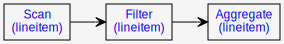

In [21]:
tc.query6()

 
SELECT
	N_NAME,
	SUM(L_EXTENDEDPRICE * (1 - L_DISCOUNT)) AS REVENUE
FROM
	CUSTOMER,
	ORDERS,
	LINEITEM,
	SUPPLIER,
	NATION,
	REGION
WHERE
	C_CUSTKEY = O_CUSTKEY
	AND L_ORDERKEY = O_ORDERKEY
	AND L_SUPPKEY = S_SUPPKEY
	AND C_NATIONKEY = S_NATIONKEY
	AND S_NATIONKEY = N_NATIONKEY
	AND N_REGIONKEY = R_REGIONKEY
	AND R_NAME = 'EUROPE'
	AND O_ORDERDATE >= DATE '1995-01-01'
	AND O_ORDERDATE < DATE '1995-01-01' + INTERVAL '1' YEAR
GROUP BY
	N_NAME
ORDER BY
	REVENUE DESC;

b'RUSSIA' = 1383634.2112000003
b'UNITED KINGDOM' = 1520153.4853999997
b'ROMANIA' = 1640527.6857999996
b'FRANCE' = 1692669.451
b'GERMANY' = 1909937.0414000002



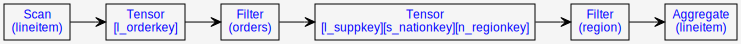

In [22]:
tc.query5()